Specify the folder where `jpq/` is installed, and import the library:

In [365]:
containing_folder = '/home/jpmarceaux/Projects/'
import sys
sys.path.insert(0, containing_folder)
from jpq import *
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import scipy
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

# Circuits in color

## Color functions

In [366]:
def bloch2rgb_lab(x, y, z):
    coord_l = 50*(1-z)
    coord_b = 128*x
    coord_a = 128*y
    color = LabColor(coord_l, coord_a, coord_b)
    rgb = convert_color(color, sRGBColor)
    r, g, b = rgb. get_upscaled_value_tuple()
    return (r, g, b)

## Embedded qubits

In [391]:
KNOWN_GATES = {
    'x': SigmaX,
    'y': SigmaY,
    'z': SigmaZ,
    'h': lambda: (1/np.sqrt(2))*np.array([[1, 1], [1, -1]]),
    's': lambda: np.array([[1, 0], [0, 1j]]),
    't': lambda: np.array([[1, 0], [0, (1+1j)/np.sqrt(2)]])
}


def embedded_1qubit(label, width):
    """channel of embedded 1-qubit gate in circuit of given width"""
    tstr = label[0]
    idx = label[1]

    try:
        if tstr == 'r':
            t = label[2]
            n = label[3] if len(label) > 3 else [1, 0, 0]
            n = np.array(n)/(n[0]**2 + n[1]**2 + n[2]**2)**0.5
            # different rotation conventions: I prefer R_v(t) = exp(tv)
            g = np.eye(2, dtype=complex)*np.cos(t) + 1j*np.sin(t) * (n[0]*SigmaX() + n[1]*SigmaY() + n[2]*SigmaZ())
        else:
            g = KNOWN_GATES[tstr]()
    except KeyError as e:
        raise ValueError(f"tchar '{tstr}' not in dictionary") from e
    
    unitary = 1
    for w in range(width):
        u_i = g if w == idx else np.eye(2, dtype=complex)
        unitary = np.kron(unitary, u_i)
    return unitary

In [392]:
def embedded_controlledU(cbit, tbit, width, U):
    """
    make unitary operation for C_U 
    [|0><0| o ... o 1] + [|1><1| o ... o U] 
    """
    assert U.shape[0] == 2 and U.shape[1] == 2, \
        "makeCU: dimension mismatch"
    I = np.eye(2, dtype=complex)
    
    m0 = 1
    m1 = 1
    for i in range(width):
        if i == cbit:
            m0 = np.kron(m0, np.array([[1, 0], [0, 0]]))
            m1 = np.kron(m1, np.array([[0, 0], [0, 1]]))
        elif i == tbit:
            m0 = np.kron(m0, I)
            m1 = np.kron(m1, U)
        else:
            m0 = np.kron(m0, I)
            m1 = np.kron(m1, I)
    return m0 + m1

In [393]:
def embedded_ccU(cbit1, cbit2, tbit, width, U):
    """
    make unitary operation for C_C_U
    [(I - |11><11|) o ... o 1] + [|11><11| o ... o U]
    """
    assert U.shape[0] == 2 and U.shape[1] == 2, \
        "makeCU: dimension mismatch"
    I = np.eye(2, dtype=complex)
    m0 = 1
    m1 = 1
    m2 = 1
    m3 = 1
    for i in range(width):
        if i == cbit1:
            m0 = np.kron(m0, np.array([[1, 0], [0, 0]]))
            m1 = np.kron(m1, np.array([[0, 0], [0, 1]]))
            m2 = np.kron(m2, np.array([[1, 0], [0, 0]]))
            m3 = np.kron(m3, np.array([[0, 0], [0, 1]]))
        elif i == cbit2:
            m0 = np.kron(m0, np.array([[1, 0], [0, 0]]))
            m1 = np.kron(m1, np.array([[1, 0], [0, 0]]))
            m2 = np.kron(m2, np.array([[0, 0], [0, 1]]))
            m3 = np.kron(m3, np.array([[0, 0], [0, 1]]))
        elif i == tbit:
            m0 = np.kron(m0, I)
            m1 = np.kron(m1, I)
            m2 = np.kron(m2, I)
            m3 = np.kron(m3, U)
        else:
            m0 = np.kron(m0, I)
            m1 = np.kron(m1, I)
            m2 = np.kron(m2, I)
            m3 = np.kron(m3, I)
    return m0 + m1 + m2 + m3

## Converting layers to channels

In [394]:
def label2channel(label, width):
    if label[0][0:2] == 'cc':
        # cc operation
        op = label[0]
        g = KNOWN_GATES[label[0][2]]()
        U = embedded_ccU(label[1], label[2], label[3], width, g)
    elif(label[0][0] == 'c'):
        # controlled operation
        op = label[0]
        if(op == 'cx'):
            g = SigmaX()
        elif(op == 'cy'):
            g = SigmaY()
        elif(op == 'cz'):
            g = SigmaZ()
        else:
            raise ValueError(f"tchar {op} not in dictionary")
        U = embedded_controlledU(label[1], label[2], width, g)
    else:
        # otherwise, 1-qubit unitary assumed
        U = embedded_1qubit(label, width)
    return Channel([U], rep='kraus')

In [395]:
def layer2channel(layer, width):
    if len(layer) > 0: 
        chnl = label2channel(layer[0], width)
        if(len(layer) > 1):
            for c in layer[1:]:
                # TODO i'm not sure this works
                chnl = compose(label2channel(c, width), chnl)
        return chnl

## Circuit class

In [396]:
class Circuit():
    def __init__(self, width, layers=None):
        self._width = width
        self._layers = layers

    def get_layer_channel(self, i):
        """Get the ith layer channel class"""
        if (i > len(self._layers) - 1):
            raise ValueError("requested layer exceeds numbers of layers in circuit")
        return(layer2channel(self._layers[i], self._width))

    def get_width(self):
        return self._width

    def get_depth(self):
        return len(self._layers)

    def get_layer(self, idx):
        return self._layers[idx]

## X-correlation display

In [397]:
def extract_correlation_coefs(rho12):
    I_1 = np.array([
        [1, 0, 0, 0], 
        [0, 0, 0, 0], 
        [0, 0, 0, 0], 
        [0, 0, 0, 1] 
        ])
    Z_1 = np.array([
        [1, 0, 0, 0], 
        [0, 0, 0, 0], 
        [0, 0, 0, 0], 
        [0, 0, 0, -1] 
        ])
    X_1 = np.array([
        [0, 0, 0, 1], 
        [0, 0, 0, 0], 
        [0, 0, 0, 0], 
        [1, 0, 0, 0] 
        ])
    Y_1 = np.array([
        [0, 0, 0, -1j], 
        [0, 0, 0, 0], 
        [0, 0, 0, 0], 
        [1j, 0, 0, 0] 
        ])
    
    I_2 = np.array([
        [0, 0, 0, 0], 
        [0, 1, 0, 0], 
        [0, 0, 1, 0], 
        [0, 0, 0, 0] 
        ])
    Z_2 = np.array([
        [0, 0, 0, 0], 
        [0, 1, 0, 0], 
        [0, 0, -1, 0], 
        [0, 0, 0, 0] 
        ])
    X_2 = np.array([
        [0, 0, 0, 0], 
        [0, 0, 1, 0], 
        [0, 1, 0, 0], 
        [0, 0, 0, 0] 
        ])
    Y_2 = np.array([
        [0, 0, 0, 0], 
        [0, 0, -1j, 0], 
        [0, 1j, 0, 0], 
        [0, 0, 0, 0] 
        ])
    
    return (
        (np.trace(Z_1@rho12).real, np.trace(Y_1@rho12).real, np.trace(X_1@rho12).real, np.trace(I_1@rho12).real), 
        (np.trace(Z_2@rho12).real, np.trace(Y_2@rho12).real, np.trace(X_2@rho12).real, np.trace(I_2@rho12).real)
    )

In [483]:
def paint_xdisplay(draw, coefs, bit1, bit2, layer_idx, tileDims, gateRatio=1/4):
    """
    For now, let's just paint a black box
    """
    dimX = tileDims[0]
    dimY = tileDims[1]
    z0, y0, x0, id0 = coefs[0]
    z1, y1, x1, id1 = coefs[1]
    
    r0, g0, b0 = bloch2rgb_lab(x0, y0, z0)
    r1, g1, b1 = bloch2rgb_lab(x1, y1, z1)
    
    alpha0 = int(255*id0)
    alpha1 = int(255*id1)
        
    rectangle_dims1 = [((layer_idx+1+gateRatio)*dimX, (bit1+0.5+gateRatio)*dimY), 
            ((layer_idx+1-gateRatio)*dimX, (bit1+0.5-gateRatio)*dimY)]
    draw.rectangle(rectangle_dims1, fill=(r0, g0, b0, alpha0), outline=(0, 0, 0))
    
    rectangle_dims2 = [((layer_idx+1+gateRatio)*dimX, (bit2+0.5+gateRatio)*dimY), 
            ((layer_idx+1-gateRatio)*dimX, (bit2+0.5-gateRatio)*dimY)]
    draw.rectangle(rectangle_dims2, fill=(r1, g1, b1, alpha1), outline=(0, 0, 0))
    # fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", int(gateRatio*2*dimY))
    
    # draw.text(((layer_idx+1)*dimX - textlength/2, rectangle_dims1[0][1]), "00+11 and 01+10 \n spaces")

## Painting the circuit

In [484]:
def local_bloch(state, subsystem, qubits):
    dims = [2 for _ in range(qubits)]
    traced = [j for j in range(qubits) if j != subsystem]
    rho = TrX(state, traced, dims)
    # the trace should be real
    return [np.trace(rho@SigmaX()).real, np.trace(rho@SigmaY()).real, np.trace(rho@SigmaZ()).real]

In [485]:
def paint_X(draw, bit, gate_name, layer_idx, tileDims, gateRatio):
    """For now, let's just paint a black box
    we'll specialize this function to paint specific gates
    in our gate set
    """
    dimX = tileDims[0]
    dimY = tileDims[1]
    dims = [((layer_idx+1-gateRatio)*dimX, (bit+0.5-gateRatio)*dimY), 
            ((layer_idx+1+gateRatio)*dimX, (bit+0.5+gateRatio)*dimY)]
    draw.rectangle(dims, fill='black')
    # fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", int(gateRatio*2*dimY))
    lenth = draw.textlength(gate_name.upper()) 
    draw.text(((layer_idx+1)*dimX - lenth/2, dims[0][1]), gate_name.upper())

def paint_controlledU(draw, cbit, tbit, gate_name, layer_idx, tileDims, gateRatio):
    """
    paints a black box and circle for now, and a line that connects them
    """
    dimX = tileDims[0]
    dimY = tileDims[1]

    line = [((layer_idx+1)*dimX, (cbit+0.5)*dimY),
           ((layer_idx+1)*dimX, (tbit+0.5)*dimY)]
    draw.rectangle(line, fill='black')

    dims = [((layer_idx+1-gateRatio)*dimX, (cbit+0.5-gateRatio)*dimY), 
            ((layer_idx+1+gateRatio)*dimX, (cbit+0.5+gateRatio)*dimY)]
    draw.ellipse(dims, fill=(255,255,255), outline='black')
    
    paint_X(draw, tbit, gate_name[1:], layer_idx, tileDims, gateRatio)
    
def paint_ccU(draw, cbit1, cbit2, tbit, gate_name, layer_idx, tileDims, gateRatio):
    dimX = tileDims[0]
    dimY = tileDims[1]
    line1 = [((layer_idx+1)*dimX, (cbit1+0.5)*dimY),
           ((layer_idx+1)*dimX, (tbit+0.5)*dimY)]
    draw.rectangle(line1, fill='black')

    line2 = [((layer_idx+1)*dimX, (cbit2+0.5)*dimY),
           ((layer_idx+1)*dimX, (tbit+0.5)*dimY)]
    draw.rectangle(line2, fill='black')

    dims1 = [((layer_idx+1-gateRatio)*dimX, (cbit1+0.5-gateRatio)*dimY), 
            ((layer_idx+1+gateRatio)*dimX, (cbit1+0.5+gateRatio)*dimY)]
    draw.ellipse(dims1, fill=(255,255,255), outline='black')
    
    dims2 = [((layer_idx+1-gateRatio)*dimX, (cbit2+0.5-gateRatio)*dimY), 
            ((layer_idx+1+gateRatio)*dimX, (cbit2+0.5+gateRatio)*dimY)]
    draw.ellipse(dims2, fill=(255,255,255), outline='black')

    paint_X(draw, tbit, gate_name[2:], layer_idx, tileDims, gateRatio)

def paint_gates(image, layer, idx, tileDims, gateRatio=1/4):
    """Paint the gates"""
    for lbl in layer:
        # this will become a switch-type interface 
        draw = ImageDraw.Draw(image)
        if lbl[0] == 'xdisp':
            None
        elif lbl[0][0:2] == 'cc':
            paint_ccU(draw, lbl[1], lbl[2], lbl[3], lbl[0], idx, tileDims, gateRatio)
        elif lbl[0][0] == 'c':
            paint_controlledU(draw, lbl[1], lbl[2], lbl[0], idx, tileDims, gateRatio)
        else:
            paint_X(draw, lbl[1], lbl[0], idx, tileDims, gateRatio)

In [486]:
class Painter():
    def __init__(self, tileDims=(50,50), wireRatio=1/4):
        self._tileDims = tileDims
        self._wireRatio = wireRatio

    def paint(self, circ, filename=None):
        """Paint the circuit"""
        # imput params
        qbits = circ.get_width()
        depth = circ.get_depth()
        tileX = self._tileDims[0]
        tileY = self._tileDims[1]
        
        height = qbits*tileY
        width = (depth+2)*tileX
        
        wireRatio = self._wireRatio
        rho = Register(qbits).mat()
        
        # [1] Allocate image 
        image = Image.open("background.png")
        image = image.resize((width, height))
        draw = ImageDraw.Draw(image, "RGBA")
        
        # paint initial layer of tiles
        for q in range(qbits):
            x, y, z = local_bloch(rho, q, qbits)
            xi, yi = int(0), int((q+0.5)*tileY)
            xf, yf = int(tileX), int(yi)
            draw.line([(xi, yi), (xf, yf)], width=int(tileY*wireRatio), fill=bloch2rgb_lab(x, y, z))
        
        # painter circuit layers
        for i in range(depth):
            layer = circ.get_layer(i)
            if layer[0][0] != 'xdisp':
                channel = circ.get_layer_channel(i)
                rho = channel.apply(rho)
                for q in range(qbits):
                    x, y, z = local_bloch(rho, q, qbits)
                    xi, yi = int((i+1)*tileX), int((q+0.5)*tileY)
                    xf, yf = int((i+2)*tileX), int(yi)
                    draw.line([(xi, yi), (xf, yf)], width=int(tileY*wireRatio), fill=bloch2rgb_lab(x, y, z))
                    paint_gates(image, layer, i, (tileX, tileY))
            else:
                for q in range(qbits):
                    x, y, z = local_bloch(rho, q, qbits)
                    xi, yi = int((i+1)*tileX), int((q+0.5)*tileY)
                    xf, yf = int((i+2)*tileX), int(yi)
                    draw.line([(xi, yi), (xf, yf)], width=int(tileY*wireRatio), fill=bloch2rgb_lab(x, y, z))
                subsystems = [i for i in range(qbits) if (i != layer[0][1]) and (i != layer[0][2])]
                sig = TrX(rho, subsystems, [2 for _ in range(qbits)])
                coefs = extract_correlation_coefs(sig)
                paint_xdisplay(draw, coefs, layer[0][1], layer[0][2], i, (tileX, tileY))
            
        
        if filename:
            image.save(filename)
        return image

## 1-qbit examples

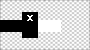

In [487]:
layers = [[('x', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

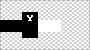

In [488]:
layers = [[('y', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

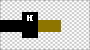

In [489]:
layers = [[('h', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

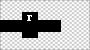

In [490]:
layers = [[('t', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

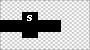

In [491]:
layers = [[('s', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

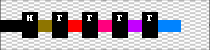

In [492]:
layers = [[('h', 0)], [('t', 0)], [('t', 0)], [('t', 0)], [('t', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

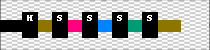

In [493]:
layers = [[('h', 0)], [('s', 0)], [('s', 0)], [('s', 0)], [('s', 0)]]
circ = Circuit(1, layers)
painter = Painter((30, 50))
painter.paint(circ)

## Examples

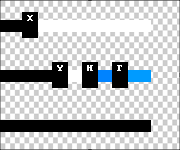

In [494]:
layers = [[('x', 0)], [('y', 1)], [('h', 1)], [('t', 1)]]
circ = Circuit(3, layers)
painter = Painter((30, 50))
painter.paint(circ)

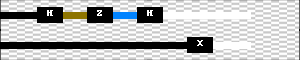

In [495]:
layers = [[('h', 0)], [('z', 0)], [('h', 0)], [ ('x', 1)]]
circ = Circuit(2, layers)
painter = Painter((50, 30))
painter.paint(circ)

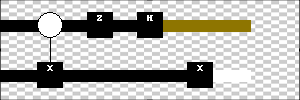

In [496]:
layers = [[('cx', 0, 1)], [('z', 0)], [('h', 0)], [ ('x', 1)]]
circ = Circuit(2, layers)
painter = Painter()
painter.paint(circ)

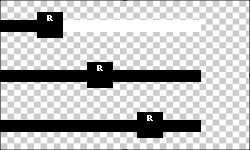

In [497]:
layers = [[('r', 0, np.pi/2)], [('r',1, np.pi)], [('r',2, 2*np.pi)]]
circ = Circuit(3, layers)
painter = Painter((50, 50))
painter.paint(circ)

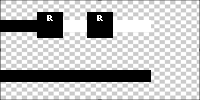

In [498]:
layers = [[('r',0, np.pi/2, [1, 0, 0])], [('r',0, np.pi/2, [0, 0, 1])]]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

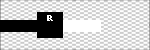

In [499]:
layers = [[('r',0, np.pi/2, [0,1, 0])]]
circ = Circuit(1, layers)
painter = Painter((50, 50))
painter.paint(circ)

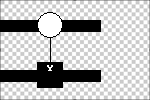

In [500]:
# There's a bug in the channel ?!?
layers = [ [('cy', 0, 1)]]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

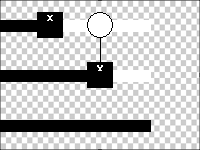

In [501]:
# There's a bug in the channel -- fixed
layers = [[('x', 0)], [('cy', 0, 1)]]
circ = Circuit(3, layers)
painter = Painter((50, 50))
painter.paint(circ)

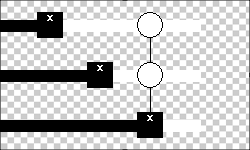

In [502]:
## toffoli
layers = [[('x', 0)], [('x', 1)], [('ccx', 0, 1, 2)]]
circ = Circuit(3, layers)
painter = Painter((50, 50))
painter.paint(circ)

## Entangled examples

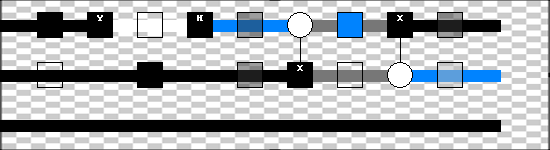

In [504]:
layers = [[('xdisp', 0, 1)], [('y', 0)], [('xdisp', 0, 1)], [('h', 0)],  [('xdisp', 0, 1)], [('cx', 0, 1)], [('xdisp', 0, 1)], [('cx', 1, 0)], [('xdisp', 0, 1)]]
circ = Circuit(3, layers)
painter = Painter((50, 50))
painter.paint(circ)

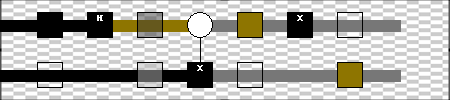

In [505]:
layers = [[('xdisp', 0, 1)], 
          [('h', 0)], 
          [('xdisp', 0, 1)],  
          [('cx', 0, 1)], 
          [('xdisp', 0, 1)], 
          [('x', 0)], 
          [('xdisp', 0, 1)]
         ]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

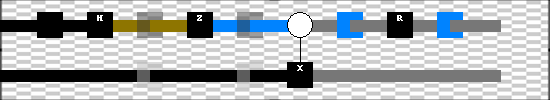

In [456]:
layers = [[('xdisp', 0, 1)], 
          [('h', 0)], 
          [('xdisp', 0, 1)],  
          [('z', 0)], 
          [('xdisp', 0, 1)],  
          [('cx', 0, 1)], 
          [('xdisp', 0, 1)], 
          [('r',0, np.pi, [0,1, 0])],
          [('xdisp', 0, 1)]
         ]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

### Bell-Pair Examples

$$ \frac{|00\rangle + |11\rangle}{\sqrt{2}} $$

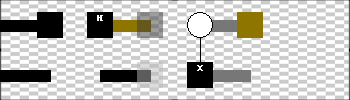

In [423]:
layers = [[('xdisp', 0, 1)], 
          [('h', 0)], 
          [('xdisp', 0, 1)],  
          [('cx', 0, 1)], 
          [('xdisp', 0, 1)], 
         ]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

$$ \frac{|01\rangle + |10\rangle}{\sqrt{2}} $$

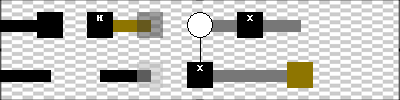

In [425]:
layers = [[('xdisp', 0, 1)], 
          [('h', 0)], 
          [('xdisp', 0, 1)],  
          [('cx', 0, 1)], 
          [('x', 0)], 
          [('xdisp', 0, 1)], 
         ]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

$$ \frac{|00\rangle - |11\rangle}{\sqrt{2}} $$

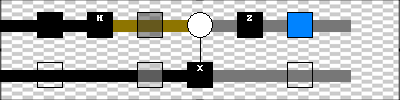

In [506]:
layers = [[('xdisp', 0, 1)], 
          [('h', 0)], 
          [('xdisp', 0, 1)],  
          [('cx', 0, 1)], 
          [('z', 0)], 
          [('xdisp', 0, 1)], 
         ]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

$$ \frac{|01\rangle - |10\rangle}{\sqrt{2}} $$

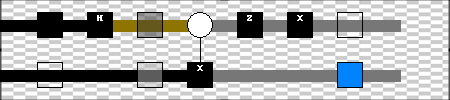

In [510]:
layers = [[('xdisp', 0, 1)], 
          [('h', 0)], 
          [('xdisp', 0, 1)],  
          [('cx', 0, 1)], 
          [('z', 0)], 
          [('x', 0)], 
          [('xdisp', 0, 1)], 
         ]
circ = Circuit(2, layers)
painter = Painter((50, 50))
painter.paint(circ)

### Random Example

In [109]:
def random_circuit_XYZHSTCnot_1D(depth, qubits):
    layers = []
    for l in range(depth):
        i = random.randint(1, 7)
        if i == 1: # X-type
            j = random.randint(0, qubits-1)
            layers.append([('x', j)])
        elif i == 2: # Y-type
            j = random.randint(0, qubits-1)
            layers.append([('y', j)])
        elif i == 3: # Z-type
            j = random.randint(0, qubits-1)
            layers.append([('z', j)])
        elif i == 4: # H-type
            j = random.randint(0, qubits-1)
            layers.append([('h', j)])
        elif i == 5: # S-type
            j = random.randint(0, qubits-1)
            layers.append([('s', j)])
        elif i == 6: # T-type
            j = random.randint(0, qubits-1)
            layers.append([('t', j)])
        elif i == 7: # Cnot-type (only neighbors)
            j = random.randint(0, qubits-1)
            k = random.randint(0, qubits-1)
            while k == j:
                k = random.randint(0, qubits-1)
            layers.append([('cx', j, k)])
                
    return layers

[[('t', 1)], [('cx', 1, 2)], [('cx', 2, 0)], [('h', 2)], [('y', 2)], [('t', 3)], [('h', 3)]]


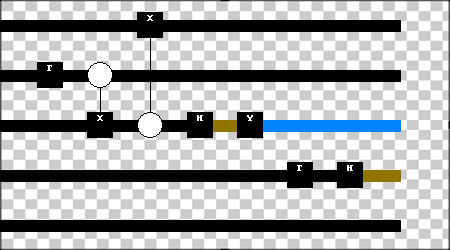

In [421]:
layers = random_circuit_XYZHSTCnot_1D(7,4)
print(layers)
circ = Circuit(5, layers)
painter = Painter()
painter.paint(circ)

### 5-bit ECC example

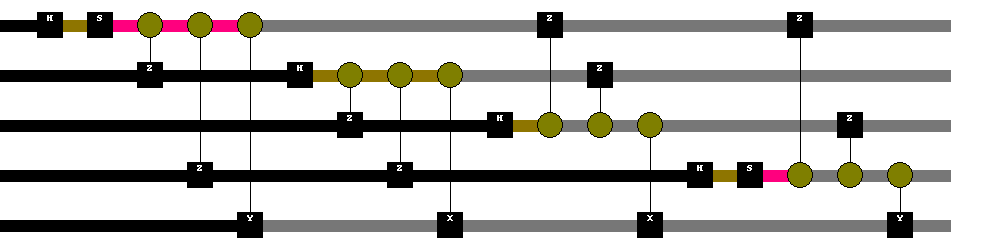

In [111]:
C5bitCode = [
    [('h', 0)], 
    [('s', 0)], 
    [('cz', 0, 1)],
    [('cz', 0, 3)],
    [('cy', 0, 4)],
    [('h', 1)],
    [('cz', 1, 2)],
    [('cz', 1, 3)],
    [('cx', 1, 4)], 
    [('h', 2)], 
    [('cz', 2, 0)], 
    [('cz', 2, 1)], 
    [('cx', 2, 4)],
    [('h', 3)], 
    [('s', 3)],
    [('cz', 3, 0)], 
    [('cz', 3, 2)], 
    [('cy', 3, 4)]
]
circ = Circuit(5, C5bitCode)
painter = Painter()
painter.paint(circ)

## TODO

- Labels for gates (DONE 2021-04-01)
- Line for controlled gates (DONE 2021-04-02)
- Rotations by $\theta$ about a general axis (DONE 2021-04-02)
- Toffoli gate (DONE 2021-04-02)
- Debug why coloring becomes gray when using C-Y or R-Y.(DONE 2021-04-16)
- measurement coloring 
- coloring the controlled bit on a CNOT (amount of control)
- entanglement diagrams (latin square-type things in a measurement basis given by local 1-qubit states)

## 